In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import json
from datetime import datetime ,timedelta

In [59]:
# opening the caltech data
with open('2019_2020.json') as f:
    data=json.load(f)
df1=pd.json_normalize(data) 


In [62]:
# dropping the fields that are not being used
df1 = df1.drop(columns=['_id','sessionID','stationID','timezone','userID','userInputs','clusterID'])


In [65]:
# JPL location has some data with a null field input for the doneChargingTime data. I updated the original JSON file to replace the null fields to an empty string.
# and then used the condition below to avoid those data.
df1=df1.loc[df1['doneChargingTime'] != "", ['siteID','disconnectTime','connectionTime','doneChargingTime','kWhDelivered',]]


In [67]:
# modifying the date and time to the correct format
df1['connectionTime'] = pd.to_datetime(df1['connectionTime'])
df1['doneChargingTime'] = pd.to_datetime(df1['doneChargingTime'])
df1['disconnectTime'] = pd.to_datetime(df1['disconnectTime'])


In [68]:
# converting time into classification for clustering
df1['c_time']=df1['connectionTime'].dt.hour*60 + df1['connectionTime'].dt.minute
df1['duration']=(df1['disconnectTime']-df1['connectionTime']).astype('timedelta64[m]')

df1['non-weedend'] = df1['connectionTime'].dt.day_name().isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype(int)
df1['weekend'] = df1['connectionTime'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

df1['morning'] = ((df1['connectionTime'].dt.time >= datetime.strptime('06:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('11:00:00', '%H:%M:%S').time())).astype(int)
df1['afternoon'] = ((df1['connectionTime'].dt.time >= datetime.strptime('11:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('15:00:00', '%H:%M:%S').time())).astype(int)
df1['evening'] = ((df1['connectionTime'].dt.time >= datetime.strptime('15:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('20:00:00', '%H:%M:%S').time())).astype(int)
df1['night'] = ((((df1['connectionTime'].dt.time >= datetime.strptime('20:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('23:59:59', '%H:%M:%S').time())).astype(int)) | (((df1['connectionTime'].dt.time >= datetime.strptime('00:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('06:00:00', '%H:%M:%S').time())).astype(int))).astype(int)

df1['Mon'] = (df1['connectionTime'].dt.day_name() == 'Monday').astype(int)
df1['Tues'] = (df1['connectionTime'].dt.day_name() == 'Tuesday').astype(int)
df1['Wed'] = (df1['connectionTime'].dt.day_name() == 'Wednesday').astype(int)
df1['Thu'] = (df1['connectionTime'].dt.day_name() == 'Thursday').astype(int)
df1['Fri'] = (df1['connectionTime'].dt.day_name() == 'Friday').astype(int)
df1['Sat'] = (df1['connectionTime'].dt.day_name() == 'Saturday').astype(int)
df1['Sun'] = (df1['connectionTime'].dt.day_name() == 'Sunday').astype(int)



In [69]:
df1.loc[(df1['connectionTime'].dt.time >= datetime.strptime('00:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('06:00:00', '%H:%M:%S').time())]


,siteID,disconnectTime,connectionTime,doneChargingTime,kWhDelivered,c_time,duration,non-weedend,weekend,morning,afternoon,evening,night,Mon,Tues,Wed,Thu,Fri,Sat,Sun
0,0002,2019-01-01 17:57:23+00:00,2019-01-01 03:45:49+00:00,2019-01-01 10:40:45+00:00,43.114,225,851.0,1,0,0,0,0,1,0,1,0,0,0,0,0
1,0002,2019-01-01 06:03:12+00:00,2019-01-01 05:28:34+00:00,2019-01-01 06:03:06+00:00,3.250,328,34.0,1,0,0,0,0,1,0,1,0,0,0,0,0
39,0002,2019-01-03 00:47:17+00:00,2019-01-03 00:22:31+00:00,2019-01-03 00:47:03+00:00,0.685,22,24.0,1,0,0,0,0,1,0,0,0,1,0,0,0
40,0002,2019-01-03 02:03:39+00:00,2019-01-03 00:23:47+00:00,2019-01-03 02:03:36+00:00,9.084,23,99.0,1,0,0,0,0,1,0,0,0,1,0,0,0
41,0002,2019-01-03 14:14:12+00:00,2019-01-03 00:37:01+00:00,2019-01-03 05:19:02+00:00,15.416,37,817.0,1,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10598,0002,2019-12-30 01:15:25+00:00,2019-12-30 00:37:58+00:00,2019-12-30 01:15:20+00:00,2.130,37,37.0,1,0,0,0,0,1,1,0,0,0,0,0,0
10599,0002,2019-12-30 03:59:47+00:00,2019-12-30 02:44:39+00:00,2019-12-30 03:49:40+00:00,2.990,164,75.0,1,0,0,0,0,1,1,0,0,0,0,0,0
10600,0002,2019-12-30 05:48:07+00:00,2019-12-30 03:03:27+00:00,2019-12-30 05:47:58+00:00,17.062,183,164.0,1,0,0,0,0,1,1,0,0,0,0,0,0
10609,0002,2019-12-31 08:39:48+00:00,2019-12-31 01:37:33+00:00,2019-12-31 03:24:51+00:00,5.463,97,422.0,1,0,0,0,0,1,0,1,0,0,0,0,0


In [70]:
# scaling
df1_trial=df1.drop(columns=['connectionTime', 'disconnectTime', 'doneChargingTime', 'siteID'])
df1_trial = (df1_trial - df1_trial.mean()) / df1_trial.std()
print(df1_trial.head())

   kWhDelivered    c_time  duration  non-weedend   weekend   morning  \
0      3.702130 -2.046648  1.386665     0.354084 -0.354084 -0.080274   
1     -0.621437 -1.752448 -0.939310     0.354084 -0.354084 -0.080274   
2     -0.876313  0.341226 -0.873829     0.354084 -0.354084 -0.080274   
3      0.385486  0.421203  0.415848     0.354084 -0.354084 -0.080274   
4     -0.878157  0.506892 -0.925075     0.354084 -0.354084 -0.080274   

   afternoon   evening     night       Mon      Tues       Wed       Thu  \
0  -0.206708 -1.332515  1.481871 -0.432062  2.087852 -0.485741 -0.465184   
1  -0.206708 -1.332515  1.481871 -0.432062  2.087852 -0.485741 -0.465184   
2  -0.206708  0.750386 -0.674756 -0.432062  2.087852 -0.485741 -0.465184   
3  -0.206708  0.750386 -0.674756 -0.432062  2.087852 -0.485741 -0.465184   
4  -0.206708  0.750386 -0.674756 -0.432062  2.087852 -0.485741 -0.465184   

       Fri       Sat       Sun  
0 -0.46189 -0.258091 -0.226884  
1 -0.46189 -0.258091 -0.226884  
2 -0.46189 

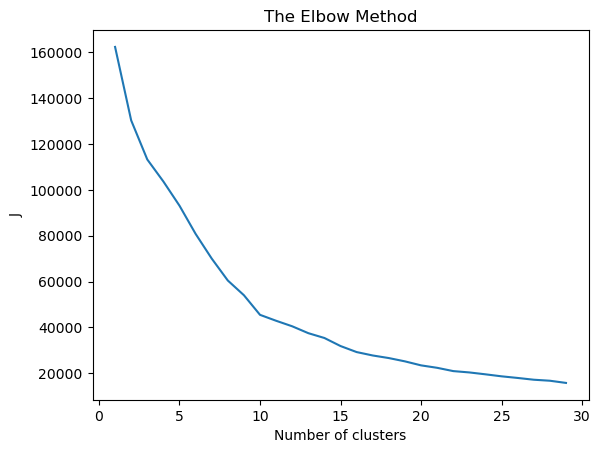

In [71]:
# Elbow method
from sklearn.cluster import KMeans
wcss = []
N_max = 30
for i in range(1, N_max):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(df1_trial)
    wcss.append(kmeans.inertia_)
    
plt.figure()
plt.plot(range(1, N_max),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('J')
plt.show()

In [72]:
kmeans = KMeans(n_clusters=7,random_state=1)
kmeans.fit(df1_trial)
print(kmeans.inertia_)

# you can check kmeans.inertia_ to see the error (the sum of squared distances)



70041.94334954563


In [73]:
df1

,siteID,disconnectTime,connectionTime,doneChargingTime,kWhDelivered,c_time,duration,non-weedend,weekend,morning,afternoon,evening,night,Mon,Tues,Wed,Thu,Fri,Sat,Sun
0,0002,2019-01-01 17:57:23+00:00,2019-01-01 03:45:49+00:00,2019-01-01 10:40:45+00:00,43.114,225,851.0,1,0,0,0,0,1,0,1,0,0,0,0,0
1,0002,2019-01-01 06:03:12+00:00,2019-01-01 05:28:34+00:00,2019-01-01 06:03:06+00:00,3.250,328,34.0,1,0,0,0,0,1,0,1,0,0,0,0,0
2,0002,2019-01-01 18:39:21+00:00,2019-01-01 17:41:45+00:00,2019-01-01 18:40:21+00:00,0.900,1061,57.0,1,0,0,0,1,0,0,1,0,0,0,0,0
3,0002,2019-01-02 02:39:32+00:00,2019-01-01 18:09:17+00:00,2019-01-01 20:16:10+00:00,12.534,1089,510.0,1,0,0,0,1,0,0,1,0,0,0,0,0
4,0002,2019-01-01 19:18:49+00:00,2019-01-01 18:39:25+00:00,2019-01-01 19:19:47+00:00,0.883,1119,39.0,1,0,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10612,0002,2019-12-31 21:54:08+00:00,2019-12-31 17:20:08+00:00,2019-12-31 21:31:04+00:00,25.159,1040,274.0,1,0,0,0,1,0,0,1,0,0,0,0,0
10613,0002,2019-12-31 20:33:01+00:00,2019-12-31 18:17:03+00:00,2019-12-31 20:32:56+00:00,15.552,1097,135.0,1,0,0,0,1,0,0,1,0,0,0,0,0
10614,0002,2020-01-01 02:20:51+00:00,2019-12-31 19:00:33+00:00,2019-12-31 21:01:39+00:00,6.618,1140,440.0,1,0,0,0,1,0,0,1,0,0,0,0,0
10615,0002,2019-12-31 22:32:13+00:00,2019-12-31 20:52:35+00:00,2019-12-31 22:32:01+00:00,5.535,1252,99.0,1,0,0,0,0,1,0,1,0,0,0,0,0


In [74]:
org_df1=df1

#  !!!!!! IMPLEMENT first add a column for the clusters to the original X dataframe in order to be able to analyze the results based on original values  !!!!!!!
org_df1.loc[:,"cluster"] = kmeans.labels_

# What percentage of the data is assigned to each cluster? 
cluster1per = org_df1['cluster'].value_counts().get(0,0)*100/len(org_df1)
cluster2per = org_df1['cluster'].value_counts().get(1,0)*100/len(org_df1)
cluster3per = org_df1['cluster'].value_counts().get(2,0)*100/len(org_df1)
cluster4per = org_df1['cluster'].value_counts().get(3,0)*100/len(org_df1)
cluster5per = org_df1['cluster'].value_counts().get(4,0)*100/len(org_df1)
cluster6per = org_df1['cluster'].value_counts().get(5,0)*100/len(org_df1)
cluster7per = org_df1['cluster'].value_counts().get(6,0)*100/len(org_df1)

print ('cluster 1:',cluster1per)
print ('cluster 2:',cluster2per)
print ('cluster 3:',cluster3per)
print ('cluster 4:',cluster4per)
print ('cluster 5:',cluster5per)
print ('cluster 6:',cluster6per)
print ('cluster 7:',cluster7per)


cluster 1: 18.658260269924146
cluster 2: 4.896069352773126
cluster 3: 19.091715101960396
cluster 4: 17.79135060585164
cluster 5: 6.245690079795094
cluster 6: 15.732440153679441
cluster 7: 17.584474436016155


In [75]:
avgDuration1 = org_df1.loc[org_df1['cluster'] == 0, 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 0, 'duration'])
avgDuration2 = org_df1.loc[org_df1['cluster'] == 1, 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 1, 'duration'])
avgDuration3 = org_df1.loc[org_df1['cluster'] == 2, 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 2, 'duration'])
avgDuration4 = org_df1.loc[org_df1['cluster'] == 3, 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 3, 'duration'])
avgDuration5 = org_df1.loc[org_df1['cluster'] == 4, 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 4, 'duration'])
avgDuration6 = org_df1.loc[org_df1['cluster'] == 5, 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 5, 'duration'])
avgDuration7 = org_df1.loc[org_df1['cluster'] == 6, 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 6, 'duration'])

print('avg duration 1:', avgDuration1)
print('avg duration 2:', avgDuration2)
print('avg duration 3:', avgDuration3)
print('avg duration 4:', avgDuration4)
print('avg duration 5:', avgDuration5)
print('avg duration 6:', avgDuration6)
print('avg duration 7:', avgDuration7)


avg duration 1: 379.98732840549104
avg duration 2: 297.30784708249496
avg duration 3: 367.18008255933955
avg duration 4: 368.71317829457365
avg duration 5: 284.9842271293375
avg duration 6: 379.96806512210395
avg duration 7: 370.78207282913166


In [82]:
kwh1 = org_df1.loc[org_df1['cluster'] == 0, 'kWhDelivered'].sum() / len(org_df1.loc[org_df1['cluster'] == 0, 'duration'])
kwh2 = org_df1.loc[org_df1['cluster'] == 1, 'kWhDelivered'].sum() / len(org_df1.loc[org_df1['cluster'] == 1, 'duration'])
kwh3 = org_df1.loc[org_df1['cluster'] == 2, 'kWhDelivered'].sum() / len(org_df1.loc[org_df1['cluster'] == 2, 'duration'])
kwh4 = org_df1.loc[org_df1['cluster'] == 3, 'kWhDelivered'].sum() / len(org_df1.loc[org_df1['cluster'] == 3, 'duration'])
kwh5 = org_df1.loc[org_df1['cluster'] == 4, 'kWhDelivered'].sum() / len(org_df1.loc[org_df1['cluster'] == 4, 'duration'])
kwh6 = org_df1.loc[org_df1['cluster'] == 5, 'kWhDelivered'].sum() / len(org_df1.loc[org_df1['cluster'] == 5, 'duration'])
kwh7 = org_df1.loc[org_df1['cluster'] == 6, 'kWhDelivered'].sum() / len(org_df1.loc[org_df1['cluster'] == 6, 'duration'])

print('avg kwh 1:', kwh1)
print('avg kwh 2:', kwh2)
print('avg kwh 3:', kwh3)
print('avg kwh 4:', kwh4)
print('avg kwh 5:', kwh5)
print('avg kwh 6:', kwh6)
print('avg kwh 7:', kwh7)

avg kwh 1: 8.736407569397915
avg kwh 2: 11.444961054661302
avg kwh 3: 8.21255692981685
avg kwh 4: 8.171146228114562
avg kwh 5: 10.001928080967403
avg kwh 6: 10.279148448715437
avg kwh 7: 8.677034900071616


In [77]:
#avg time people in each cluster disconnect after connecting them in the NIGHT
avgDuration1 = org_df1.loc[org_df1['cluster'] == 0 & ((df1['connectionTime'].dt.time >= datetime.strptime('20:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('23:59:59', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 0, 'duration'])
avgDuration2 = org_df1.loc[org_df1['cluster'] == 1 & ((df1['connectionTime'].dt.time >= datetime.strptime('20:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('23:59:59', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 1, 'duration'])
avgDuration3 = org_df1.loc[org_df1['cluster'] == 2 & ((df1['connectionTime'].dt.time >= datetime.strptime('20:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('23:59:59', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 2, 'duration'])
avgDuration4 = org_df1.loc[org_df1['cluster'] == 3 & ((df1['connectionTime'].dt.time >= datetime.strptime('20:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('23:59:59', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 3, 'duration'])
avgDuration5 = org_df1.loc[org_df1['cluster'] == 4 & ((df1['connectionTime'].dt.time >= datetime.strptime('20:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('23:59:59', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 4, 'duration'])
avgDuration6 = org_df1.loc[org_df1['cluster'] == 5 & ((df1['connectionTime'].dt.time >= datetime.strptime('20:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('23:59:59', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 5, 'duration'])
avgDuration7 = org_df1.loc[org_df1['cluster'] == 6 & ((df1['connectionTime'].dt.time >= datetime.strptime('20:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('23:59:59', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 6, 'duration'])

print('avg time people stay connceted after connecting them in the NIGHT')
print('avg duration 1:', avgDuration1)
print('avg duration 2:', avgDuration2)
print('avg duration 3:', avgDuration3)
print('avg duration 4:', avgDuration4)
print('avg duration 5:', avgDuration5)
print('avg duration 6:', avgDuration6)
print('avg duration 7:', avgDuration7)


avg time people stay connceted after connecting them in the NIGHT
avg duration 1: 379.98732840549104
avg duration 2: 1403.456740442656
avg duration 3: 371.36016511867905
avg duration 4: 386.22259136212625
avg duration 5: 1135.1671924290222
avg duration 6: 436.7676894176581
avg duration 7: 403.1910364145658


In [78]:
#avg time people in each cluster disconnect after connecting them in the MORNING
avgDuration1 = org_df1.loc[org_df1['cluster'] == 0 & ((df1['connectionTime'].dt.time >= datetime.strptime('06:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('11:00:00', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 0, 'duration'])
avgDuration2 = org_df1.loc[org_df1['cluster'] == 1 & ((df1['connectionTime'].dt.time >= datetime.strptime('06:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('11:00:00', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 1, 'duration'])
avgDuration3 = org_df1.loc[org_df1['cluster'] == 2 & ((df1['connectionTime'].dt.time >= datetime.strptime('06:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('11:00:00', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 2, 'duration'])
avgDuration4 = org_df1.loc[org_df1['cluster'] == 3 & ((df1['connectionTime'].dt.time >= datetime.strptime('06:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('11:00:00', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 3, 'duration'])
avgDuration5 = org_df1.loc[org_df1['cluster'] == 4 & ((df1['connectionTime'].dt.time >= datetime.strptime('06:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('11:00:00', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 4, 'duration'])
avgDuration6 = org_df1.loc[org_df1['cluster'] == 5 & ((df1['connectionTime'].dt.time >= datetime.strptime('06:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('11:00:00', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 5, 'duration'])
avgDuration7 = org_df1.loc[org_df1['cluster'] == 6 & ((df1['connectionTime'].dt.time >= datetime.strptime('06:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('11:00:00', '%H:%M:%S').time())), 'duration'].sum() / len(org_df1.loc[org_df1['cluster'] == 6, 'duration'])

print('avg time people stay connceted after connecting them in the Morning')
print('avg duration 1:', avgDuration1)
print('avg duration 2:', avgDuration2)
print('avg duration 3:', avgDuration3)
print('avg duration 4:', avgDuration4)
print('avg duration 5:', avgDuration5)
print('avg duration 6:', avgDuration6)
print('avg duration 7:', avgDuration7)

avg time people stay connceted after connecting them in the Morning
avg duration 1: 379.98732840549104
avg duration 2: 1476.241448692153
avg duration 3: 371.36016511867905
avg duration 4: 406.25249169435216
avg duration 5: 1135.1671924290222
avg duration 6: 459.4189104571071
avg duration 7: 403.1910364145658
